# Projet 5 : Segmentez des clients d'un site e-commerce

## Notebook 2 : Essais

In [1]:
# importation des bibliothèques nécessaires
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler,scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import decomposition
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split

In [2]:
# On importe le dataset total crée dans le notebook d'analyses exploratoires
df_total = pd.read_csv('df_total.csv', index_col = 0)
df_total.head()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,order_item_id,product_id,price,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,1.0,87285b34884572647811a353c7ac498a,29.99,1.0,credit_card,1.0,18.12,4.0,appliances
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,1.0,87285b34884572647811a353c7ac498a,29.99,3.0,voucher,1.0,2.00,4.0,appliances
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,1.0,87285b34884572647811a353c7ac498a,29.99,2.0,voucher,1.0,18.59,4.0,appliances
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-18 14:44:43,3a51803cc0d012c3b5dc8b7528cb05f7,1.0,87285b34884572647811a353c7ac498a,29.99,1.0,credit_card,3.0,37.77,4.0,appliances
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-07 18:30:01,ef0996a1a279c26e7ecbd737be23d235,1.0,87285b34884572647811a353c7ac498a,29.99,1.0,credit_card,1.0,37.77,5.0,appliances


In [3]:
#On va mettre les variables de date sous forme de date
df_total['order_purchase_timestamp'] = df_total['order_purchase_timestamp'].astype('datetime64[ns]')
df_total['order_delivered_customer_date'] = df_total['order_delivered_customer_date'].astype('datetime64[ns]')


### Dataframe par commande

#### On regarde une même commande :

- order id : identifiant unique donné lors de la commande
- customer id : identifiant donné au client lors de la commande
- customer unique id : identifiant unique d'un client
- price : le prix du produit 
- score : score par commande
- payment value : montant de la commande : transaction value 
- payment_installments : paiement echelonné : nombre d'echelons demandés par le client
- payment_sequential : compte les differents paiement : un client peut payer une commande avec plusieurs moyens de paiement 
- order_item_id : compte le nombre de produit dans la commande

In [4]:
#On fait une aggregation pour avoir un dataframe avec une ligne par commande
dict_agg = {'customer_unique_id':'first',
            'order_purchase_timestamp':'first', #un date par commande
            'order_delivered_customer_date':'first', #une date par commande
            'order_item_id':'max', #avoir le nombre de produits dans la commande
           'payment_value':'first', # le payment_value est le prix de la commande
           'review_score':'first', # un score par commande
           'product_category_name':'unique'}

df_per_order = df_total.groupby(["order_id"]).agg(dict_agg)
df_per_order = df_per_order.reset_index()

In [5]:
df_per_order.head()

,order_id,customer_unique_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,payment_value,review_score,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,2017-09-20 23:43:48,1.0,72.19,5.0,[other]
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,2017-05-12 16:04:24,1.0,259.83,4.0,[garden_pets]
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,2018-01-22 13:19:16,1.0,216.87,5.0,[home]
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,2018-08-14 13:32:39,1.0,25.78,4.0,[health_beauty]
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,2017-03-01 16:42:31,1.0,218.04,5.0,[garden_pets]


#### on verifie pour une commande

In [6]:
df_per_order[df_per_order['payment_value'] == 13664.080000]

,order_id,customer_unique_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,payment_value,review_score,product_category_name
1432,03caa2c082116e1d31e67e9ae3700499,0a0a92112bd4c708ca5fde585afaa872,2017-09-29 15:24:52,2017-10-17 18:22:29,8.0,13664.08,1.0,[electronics]


In [7]:
# 8 produits d'une valeur de 1680 : prix total 13664
df_total[df_total['customer_unique_id'] == '0a0a92112bd4c708ca5fde585afaa872'].sort_values(by='payment_sequential')

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,order_item_id,product_id,price,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name
68452,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872,1.0,5769ef0a239114ac3a854af00df129e4,1680.0,1.0,credit_card,1.0,13664.08,1.0,electronics
68453,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872,2.0,5769ef0a239114ac3a854af00df129e4,1680.0,1.0,credit_card,1.0,13664.08,1.0,electronics
68454,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872,3.0,5769ef0a239114ac3a854af00df129e4,1680.0,1.0,credit_card,1.0,13664.08,1.0,electronics
68455,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872,4.0,5769ef0a239114ac3a854af00df129e4,1680.0,1.0,credit_card,1.0,13664.08,1.0,electronics
68456,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872,5.0,5769ef0a239114ac3a854af00df129e4,1680.0,1.0,credit_card,1.0,13664.08,1.0,electronics
68457,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872,6.0,5769ef0a239114ac3a854af00df129e4,1680.0,1.0,credit_card,1.0,13664.08,1.0,electronics
68458,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872,7.0,5769ef0a239114ac3a854af00df129e4,1680.0,1.0,credit_card,1.0,13664.08,1.0,electronics
68459,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,2017-10-17 18:22:29,0a0a92112bd4c708ca5fde585afaa872,8.0,5769ef0a239114ac3a854af00df129e4,1680.0,1.0,credit_card,1.0,13664.08,1.0,electronics


### On encode les variables quantitatives : 

In [8]:
#On va encoder la variable catégorielle : product_category_name
df_per_order = (df_per_order.join(df_per_order.pop('product_category_name')
              .apply('|'.join)
              .str.get_dummies()))

In [9]:
df_per_order.head()

,order_id,customer_unique_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,payment_value,review_score,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other,sports_leisure
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,2017-09-20 23:43:48,1.0,72.19,5.0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,2017-05-12 16:04:24,1.0,259.83,4.0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,2018-01-22 13:19:16,1.0,216.87,5.0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,2018-08-14 13:32:39,1.0,25.78,4.0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,2017-03-01 16:42:31,1.0,218.04,5.0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [10]:
df_per_order[df_per_order['order_id'] =='1fcbc88015c88c1a14d4b8ec35ea8ed7']

,order_id,customer_unique_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,payment_value,review_score,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other,sports_leisure
11977,1fcbc88015c88c1a14d4b8ec35ea8ed7,6bf558c1aae5004b6a410c3294c5e119,2018-06-30 14:37:39,2018-07-14 11:44:29,3.0,243.4,5.0,0,0,0,0,0,0,0,1,0,1,0,0,1


### Dataset par client

In [11]:
#On fait une aggregation pour avoir un dataframe par client unique
dict_agg_customer = {'order_id':'count', #pour savoir le nombre de commandes par client
                     'order_purchase_timestamp':'max', #date d'achat de la dernière commande
                     'order_delivered_customer_date':'max', #date de livraison de la dernière commande
                     'order_item_id':'sum', #avoir le nombre de produits acheté par le client
                     'payment_value':'sum', # montant total depensé par le client
                     'review_score':'mean', # le score moyen que le client a donné
                     'appliances':'max',
                     'arts':'max',
                     'auto':'max',
                     'construction':'max',
                     'electronics':'max', 
                     'fashion':'max', 
                     'food_drinks':'max',
                     'garden_pets':'max',
                     'health_beauty':'max',
                     'home':'max',
                     'office':'max',
                     'other':'max',
                     'sports_leisure':'max'} 

df_per_customer = df_per_order.groupby(["customer_unique_id"]).agg(dict_agg_customer)
df_per_customer = df_per_customer.reset_index()
df_per_customer = df_per_customer.rename(columns = {'order_id':'nbr_commandes',
                                                   'order_purchase_timestamp':'date_achat_derniere_commande',
                                                   'order_delivered_customer_date':'date_livraison_derniere_commande', #date de livraison de la dernière commande
                                                    'order_item_id':'nbr_pdt_achetés', #avoir le nombre de produits acheté par le client
                                                    'payment_value':'montant_depensé', # montant total depensé par le client
                                                    'review_score':'score_moyen'})

In [12]:
df_per_customer.head()

,customer_unique_id,nbr_commandes,date_achat_derniere_commande,date_livraison_derniere_commande,nbr_pdt_achetés,montant_depensé,score_moyen,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other,sports_leisure
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-16 20:48:37,1.0,141.90,5.0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-10 18:02:42,1.0,27.19,4.0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-04-05 14:38:47,1.0,86.22,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-11-01 21:23:05,1.0,43.62,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-27 23:08:56,1.0,196.89,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [13]:
df_per_customer.describe()

,nbr_commandes,nbr_pdt_achetés,montant_depensé,score_moyen,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other,sports_leisure
count,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000,93349.000000
mean,1.033423,1.180366,162.483085,4.153263,0.077773,0.052866,0.040365,0.022860,0.157988,0.082250,0.010027,0.054752,0.153446,0.174303,0.043246,0.055705,0.096327
std,0.209107,0.620856,223.930832,1.276088,0.267815,0.223767,0.196814,0.149459,0.364731,0.274747,0.099632,0.227496,0.360418,0.379372,0.203412,0.229352,0.295040
min,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,61.320000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,106.090000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,180.040000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.000000,24.000000,13664.080000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### On verifie si cela correspond bien à ce qu'on veut

In [14]:
df_per_customer[df_per_customer['nbr_pdt_achetés'] == 24]

,customer_unique_id,nbr_commandes,date_achat_derniere_commande,date_livraison_derniere_commande,nbr_pdt_achetés,montant_depensé,score_moyen,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other,sports_leisure
73121,c8460e4251689ba205045f3ea17884a1,4,2018-08-08 14:27:15,2018-08-21 17:18:55,24.0,4655.91,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [15]:
# Ce client a realisé 4 commandes 
# avec en tout 24 produits
# avec un montant de 1047.99 + 1202.64 + 1202.64 + 1202.64 = 4655.91
df_total[df_total['customer_unique_id'] == 'c8460e4251689ba205045f3ea17884a1']

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,order_item_id,product_id,price,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name
12228,cb1f3a44e8b8527e16913306a4d3de2f,dbe9495069f4ddb6875dfc83462d616f,2018-08-07 09:03:02,2018-08-15 19:28:29,c8460e4251689ba205045f3ea17884a1,1.0,e7cc48a9daff5436f63d3aad9426f28b,170.0,1.0,credit_card,6.0,1202.64,4.0,electronics
12229,cb1f3a44e8b8527e16913306a4d3de2f,dbe9495069f4ddb6875dfc83462d616f,2018-08-07 09:03:02,2018-08-15 19:28:29,c8460e4251689ba205045f3ea17884a1,2.0,e7cc48a9daff5436f63d3aad9426f28b,170.0,1.0,credit_card,6.0,1202.64,4.0,electronics
12230,cb1f3a44e8b8527e16913306a4d3de2f,dbe9495069f4ddb6875dfc83462d616f,2018-08-07 09:03:02,2018-08-15 19:28:29,c8460e4251689ba205045f3ea17884a1,3.0,e7cc48a9daff5436f63d3aad9426f28b,170.0,1.0,credit_card,6.0,1202.64,4.0,electronics
12231,cb1f3a44e8b8527e16913306a4d3de2f,dbe9495069f4ddb6875dfc83462d616f,2018-08-07 09:03:02,2018-08-15 19:28:29,c8460e4251689ba205045f3ea17884a1,4.0,e7cc48a9daff5436f63d3aad9426f28b,170.0,1.0,credit_card,6.0,1202.64,4.0,electronics
12232,cb1f3a44e8b8527e16913306a4d3de2f,dbe9495069f4ddb6875dfc83462d616f,2018-08-07 09:03:02,2018-08-15 19:28:29,c8460e4251689ba205045f3ea17884a1,5.0,e7cc48a9daff5436f63d3aad9426f28b,170.0,1.0,credit_card,6.0,1202.64,4.0,electronics
12233,cb1f3a44e8b8527e16913306a4d3de2f,dbe9495069f4ddb6875dfc83462d616f,2018-08-07 09:03:02,2018-08-15 19:28:29,c8460e4251689ba205045f3ea17884a1,6.0,e7cc48a9daff5436f63d3aad9426f28b,170.0,1.0,credit_card,6.0,1202.64,4.0,electronics
12245,03aba68b07658f28f29612641f08d4ba,a7ab31829dc9a10f37e82b1e1afd26b6,2018-08-08 14:27:15,2018-08-21 15:33:32,c8460e4251689ba205045f3ea17884a1,1.0,e7cc48a9daff5436f63d3aad9426f28b,170.0,1.0,credit_card,6.0,1202.64,4.0,electronics
12246,03aba68b07658f28f29612641f08d4ba,a7ab31829dc9a10f37e82b1e1afd26b6,2018-08-08 14:27:15,2018-08-21 15:33:32,c8460e4251689ba205045f3ea17884a1,2.0,e7cc48a9daff5436f63d3aad9426f28b,170.0,1.0,credit_card,6.0,1202.64,4.0,electronics
12247,03aba68b07658f28f29612641f08d4ba,a7ab31829dc9a10f37e82b1e1afd26b6,2018-08-08 14:27:15,2018-08-21 15:33:32,c8460e4251689ba205045f3ea17884a1,3.0,e7cc48a9daff5436f63d3aad9426f28b,170.0,1.0,credit_card,6.0,1202.64,4.0,electronics
12248,03aba68b07658f28f29612641f08d4ba,a7ab31829dc9a10f37e82b1e1afd26b6,2018-08-08 14:27:15,2018-08-21 15:33:32,c8460e4251689ba205045f3ea17884a1,4.0,e7cc48a9daff5436f63d3aad9426f28b,170.0,1.0,credit_card,6.0,1202.64,4.0,electronics


### Creation des variables RFM 
- Récence : durée depuis la dernière commande
- Fréquence : nombre de commandes 
- Montant: par exemple montant cumulé des commandes

In [16]:
# On prends la date de derniére commande comme notre date de comparaison
ref_date = df_total['order_purchase_timestamp'].max()
ref_date

Timestamp('2018-08-29 15:00:37')

In [17]:
df_RFM = df_per_customer[['date_achat_derniere_commande','nbr_commandes','montant_depensé']]
# On renomme les colonnes 
df_RFM.rename(columns={'nbr_commandes':"Frequency",
                       'montant_depensé' :'Monetary'}, inplace=True)
# on crée la variable Recency
df_RFM['Recency'] = df_RFM['date_achat_derniere_commande'].apply(lambda x: (ref_date - x).days)
#On supprime la colonne dont on a pas besoin
df_RFM.drop(columns = ['date_achat_derniere_commande'], inplace=True)
df_RFM = df_RFM.reset_index()
#on garde que les 3 colonnes dont on a besoin
df_RFM=df_RFM[['Recency', 'Frequency', 'Monetary']]
df_RFM.head()

,Recency,Frequency,Monetary
0,111,1,141.90
1,114,1,27.19
2,536,1,86.22
3,320,1,43.62
4,287,1,196.89


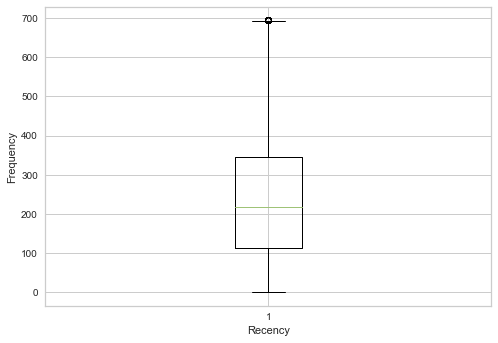

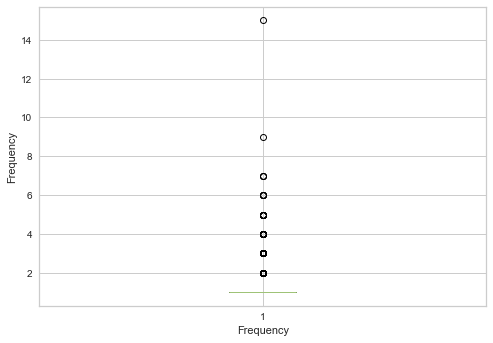

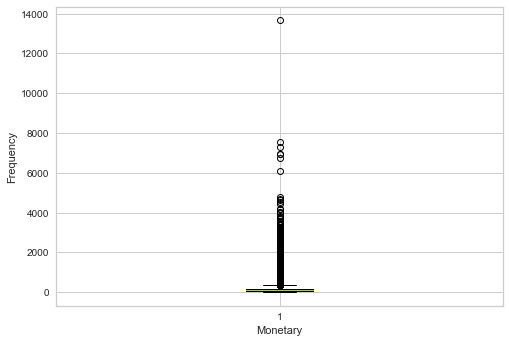

In [18]:
#on afficher les boxplots des variables RFM
for i in ["Recency", "Frequency", "Monetary"]:
    plt.figure()
    plt.tight_layout()
    plt.gca().set(xlabel= i, ylabel='Frequency')
    plt.boxplot(df_RFM[i])


In [19]:
# On normalise les données pour qu'elles aient toutes la même importance

minmax_scaler= MinMaxScaler()
X_scaled_RFM = minmax_scaler.fit_transform(df_RFM)

df_RFM_scaled = pd.DataFrame(X_scaled_RFM)
df_RFM_scaled.columns = ['Recency', 'Frequency', 'Monetary']
df_RFM_scaled.head()

,Recency,Frequency,Monetary
0,0.159942,0.0,0.010384
1,0.164265,0.0,0.001989
2,0.772334,0.0,0.006309
3,0.461095,0.0,0.003192
4,0.413545,0.0,0.014409


### Premier clustering avec les 3 variables RFM

#### Algorithme de K-means
Étant donnés des points et un entier k, l'algorithme vise à diviser les points en k groupes, appelés clusters, homogènes et compacts.

#### Methode du coude "Elbow Method" : detecter une zone de coude dans la minimisation du cout (inertia)
On trace l'evolution du cout de notre modele en fonction du nombre de clusters pour detecter la zone de coude : nous indique le nombre de cluster optimal (qui reduit au max le cout de notre modèle)


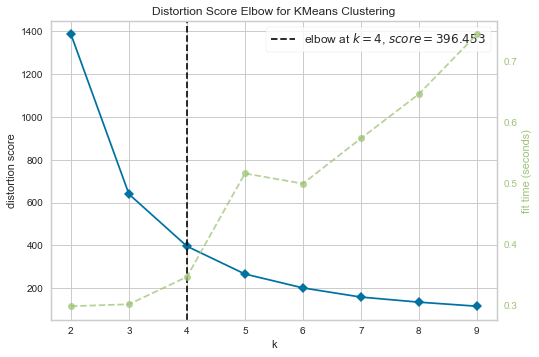

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Distorsion Score : sum of squared distances from each point to its assigned center
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_scaled_RFM)   # Fit the data to the visualizer
visualizer.poof()             # Draw/show/poof the data

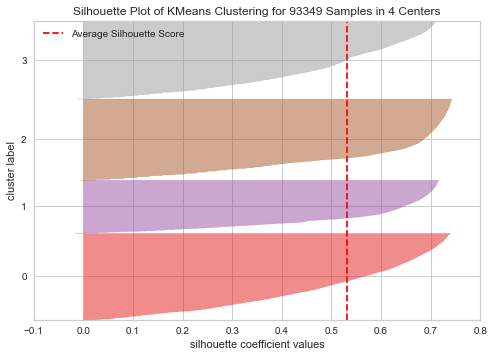

In [21]:
#Silhouette Visualizer 
#Silhouette analysis can be used to evaluate the density and separation between clusters
# Instantiate the clustering model and visualizer
kmeans_RFM = KMeans(visualizer.elbow_value_)
visualizer = SilhouetteVisualizer(kmeans_RFM)

visualizer.fit(X_scaled_RFM)        # Fit the data to the visualizer
visualizer.poof();                  # Draw/show/poof the data

Le score moyen de silhouette est à plus de 0.5 donc on peut dire que c'est acceptable

In [22]:
# On peut stocker nos clusters dans une variable labels : 
labels_RFM = kmeans_RFM.labels_
labels_RFM

array([2, 2, 1, ..., 1, 2, 1], dtype=int32)

#### On réalise une PCA pour visualiser les clusters

In [23]:
# on regarde a quoi ressemble les clusters avec une ACP pour projeter les données sur 3 dimensions
pca_RFM = decomposition.PCA(n_components=2)
pca_RFM.fit(X_scaled_RFM)

# Pourcentage de variance expliqué par la premiere composente et par les deux premieres composantes ensemble :
print(pca_RFM.explained_variance_ratio_.cumsum())
X_proj_RFM = pca_RFM.transform(X_scaled_RFM)
X_proj_RFM = pd.DataFrame(X_proj_RFM, columns = ["PC1", "PC2"])
X_proj_RFM[:10]
# On a 99% de la variance des données qui expliqué par ces deux premières composantes
# on peut dire que c'est pas absurde d'utiliser ces 2 composantes pour representer les données


[0.98993352 0.99573312]


,PC1,PC2
0,-0.181472,-0.002600
1,-0.177146,-0.010126
2,0.430921,-0.005601
3,0.119683,-0.008730
4,0.072128,0.001280
5,-0.132482,-0.000902
6,-0.152651,-0.009562
7,-0.079176,0.015711
8,0.439564,-0.001397
9,-0.097899,-0.003308


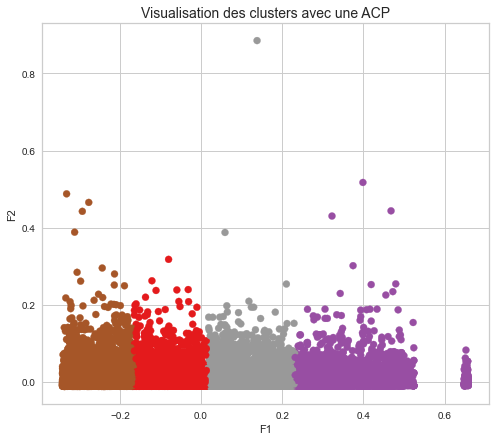

In [24]:
#on affihce les clusters
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.scatter(X_proj_RFM.iloc[:, 0], X_proj_RFM.iloc[:, 1], c= labels_RFM, cmap="Set1")
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.title('Visualisation des clusters avec une ACP', size=14)
plt.show()

In [25]:
# Pour chaque valeur « k » sélectionnée, on vérifie le nombre de clients par cluster.
# Si ce nombre est trop faible pour certains clusters, la valeur « k » n’est pas pertinente d’un point de vue métier. 
df_RFM['cluster'] = labels_RFM
df_RFM['cluster'].value_counts()

0    27118
2    25353
3    24269
1    16609
Name: cluster, dtype: int64

#### Pour chaque feature, un graphique de boxplot par cluster

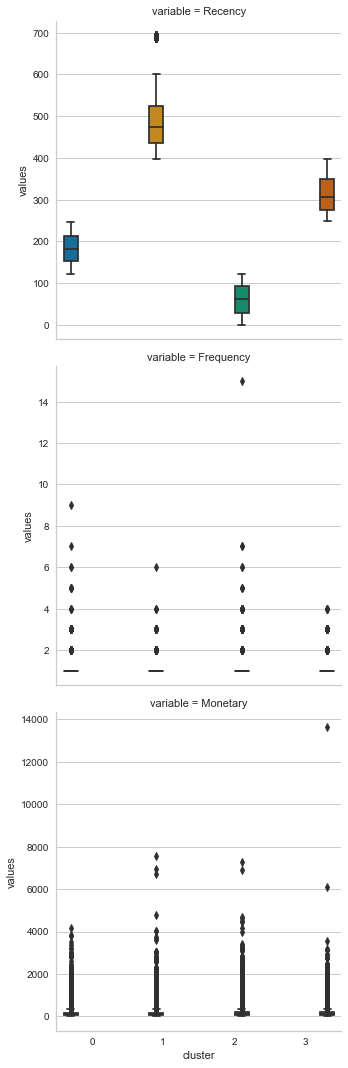

In [26]:
df_long = df_RFM.melt(id_vars='cluster',
                    value_vars=df_RFM.columns[:-1],
                    var_name='variable', 
                    value_name='values')

sns.catplot(kind='box', data=df_long, 
            col='variable', 
            y='values', 
            x='cluster',
            hue='cluster',
            palette="colorblind",
            sharey=False, 
            col_wrap=1)

plt.tight_layout()
plt.show()

#### Des graphiques d’analyse bivariée entre 2 features

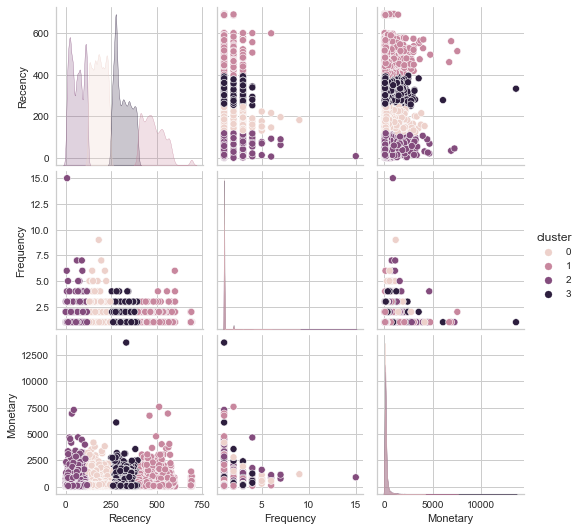

In [27]:
sns.pairplot(df_RFM, hue="cluster")

#### Pour chaque feature, un calcul de moyenne par cluster. 

In [28]:
group_columns = df_RFM.groupby('cluster').mean()
group_columns.head()

,Recency,Frequency,Monetary
cluster,,,
0,182.714986,1.035106,159.089607
1,482.515022,1.024866,160.083121
2,61.250266,1.038773,167.118198
3,313.022415,1.031810,163.075254


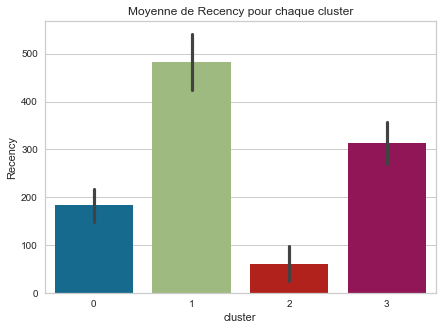

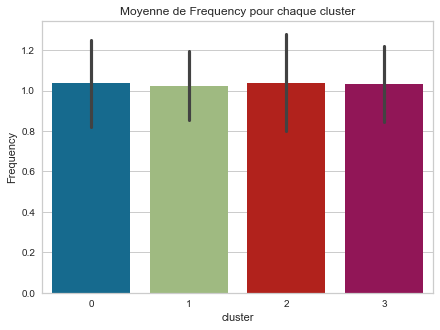

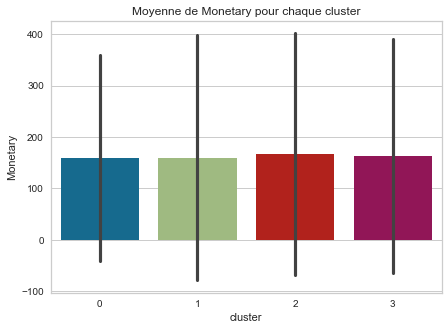

In [29]:
for column in group_columns.columns:
    try:
        plt.figure(figsize=(7,5))
        titre = 'Moyenne de ' + str(column) + ' pour chaque cluster' 
        plt.title(titre)
        sns.barplot(x = 'cluster',
                    y = column,
                    data = df_RFM, 
                    ci="sd")
        plt.show()
    except:
        print('Erreur colonne : ', column)

**On peut voir que les variables RFM ne sont pas suffisantes pour mieux connaitre les clients donc on va essayer de rajouter des varibales** 

## Rajout de variables 
On fait d’autres simulations avec des features supplémentaires qui pourraient apporter de la valeur pour séparer les bons clients des autres. 

In [30]:
# On renomme les colonnes 
df = df_per_customer.copy() 
df.rename(columns={'nbr_commandes':"Frequency",
                   'montant_depensé' :'Monetary'}, inplace=True)

df['Recency'] = df['date_achat_derniere_commande'].apply(lambda x: (ref_date - x).days)
df['delai livraison'] = df['date_livraison_derniere_commande'] - df['date_achat_derniere_commande']
df['delai livraison'] = df['delai livraison'].apply(lambda x: x.days)

#On supprime la colonne dont on a pas besoin
df.drop(columns = ['date_achat_derniere_commande','date_livraison_derniere_commande'], inplace=True)
df = df.drop(columns = 'customer_unique_id')
df.head()

,Frequency,nbr_pdt_achetés,Monetary,score_moyen,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other,sports_leisure,Recency,delai livraison
0,1,1.0,141.90,5.0,0,0,0,0,0,0,0,0,0,1,0,0,0,111,6
1,1,1.0,27.19,4.0,0,0,0,0,0,0,0,0,1,0,0,0,0,114,3
2,1,1.0,86.22,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,536,25
3,1,1.0,43.62,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,320,20
4,1,1.0,196.89,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,287,13


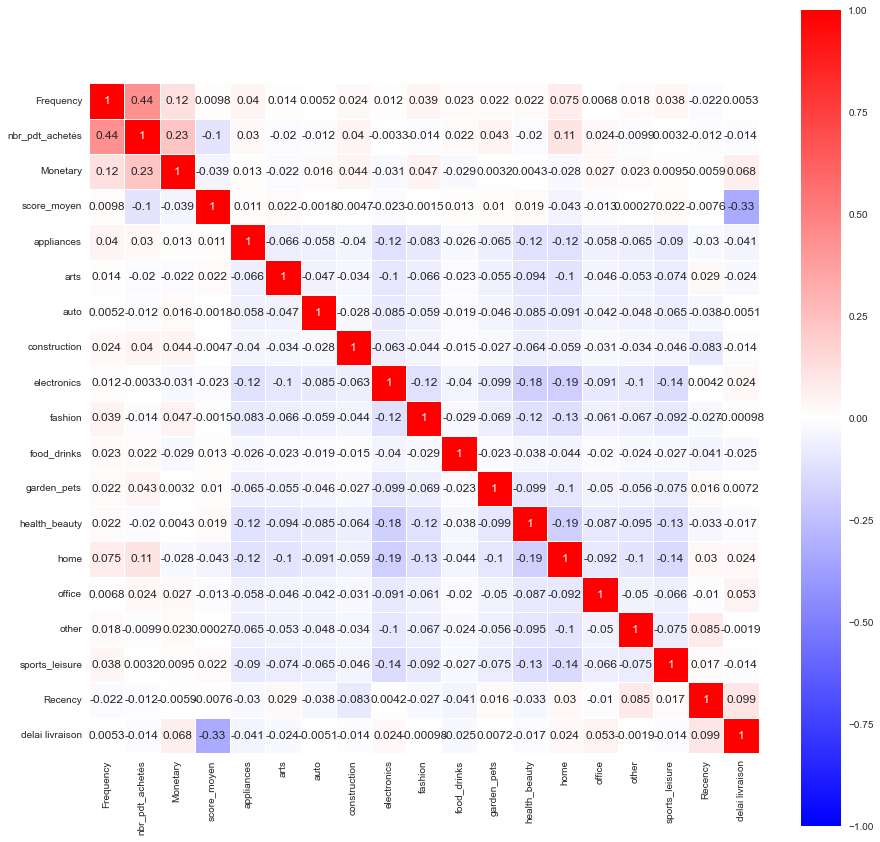

In [31]:
#on regarde la correlation des variables 
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(),annot = True, cmap = 'bwr',vmin = -1, vmax = 1, square = True, linewidths = 0.5);

### Deuxième essai
On essait avec toutes les variables pour voir ce que ça donne

In [32]:
df_all = df.copy()

In [33]:
#On standardise les données 
df_all=df_all.reset_index(drop=True)
scaler = MinMaxScaler()

X_scaled_all = scaler.fit_transform(df_all)
df_all_scaled = pd.DataFrame(X_scaled_all)
df_all_scaled.columns = df_all.columns
df_all_scaled.head()

,Frequency,nbr_pdt_achetés,Monetary,score_moyen,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other,sports_leisure,Recency,delai livraison
0,0.0,0.0,0.010384,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.159942,0.028708
1,0.0,0.0,0.001989,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.164265,0.014354
2,0.0,0.0,0.006309,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.772334,0.119617
3,0.0,0.0,0.003192,0.75,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.461095,0.095694
4,0.0,0.0,0.014409,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413545,0.062201


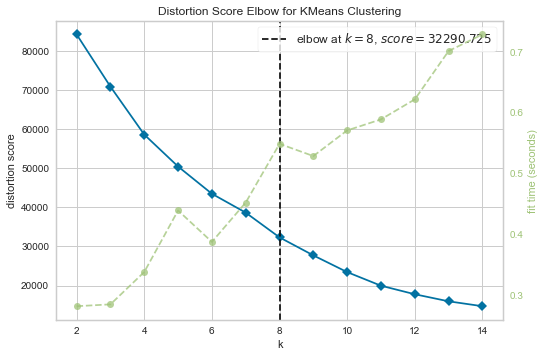

In [34]:
# Methode du coude "Elbow Method" : detecter une zone de coude dans la minimisation du cout (inertia)
# On trace l'evolution du cout de notre modele en fonction du nombre de clusters 
# pour detecter la zone de coude : nous indique le nombre de cluster optimal (qui reduit au max le cout de notre modèle)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(X_scaled_all)    # Fit the data to the visualizer
visualizer.poof();             # Draw/show/poof the data

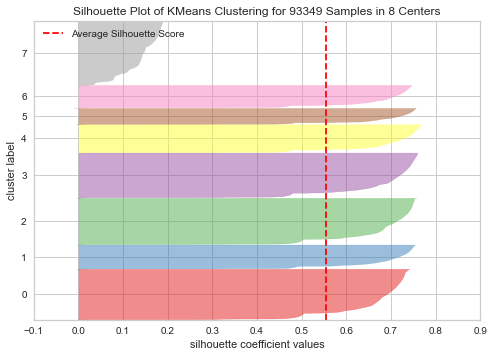

In [35]:
# Instantiate the clustering model and visualizer 
kmeans_all = KMeans(visualizer.elbow_value_)
visualizer = SilhouetteVisualizer(kmeans_all)

visualizer.fit(X_scaled_all)    # Fit the data to the visualizer
visualizer.poof();            # Draw/show/poof the data

On voit une repartition inégale des clusters.
On va donc tester d'autres types de métriques pour trouver le meilleur K :

- Silouhette : rapport moyen entre la distance intra-cluster et la distance du cluster le plus proche,
- Calinski Harabasz : rapport entre la dispersion des grappes dans et entre les groupes

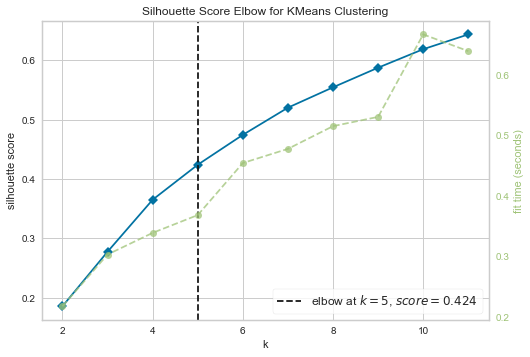

In [36]:
# Silhouette
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), metric = "silhouette")

visualizer.fit(X_scaled_all)    # Fit the data to the visualizer
visualizer.poof();    # Draw/show/poof the data

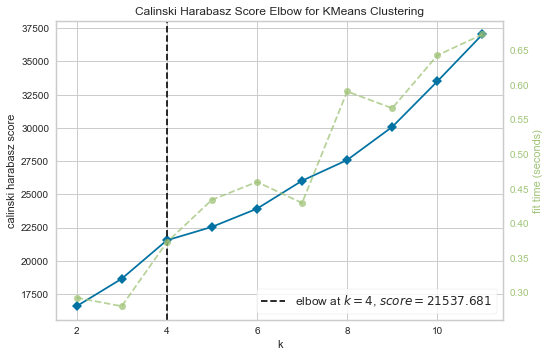

In [37]:
# Calinski Harabasz
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), metric = "calinski_harabasz")

visualizer.fit(X_scaled_all)    # Fit the data to the visualizer
visualizer.poof();            # Draw/show/poof the data

On remarque que :
- pour la métrique silhouette score, le nombre de K est de 5
- Pour le score Calinski Harabasz, le meilleur K est 4

Les scores sur la répartition en 3 clusters semblent être meilleurs.
On va donc conserver ce clustering en 3 groupes

In [38]:
#Pour chaque valeur « k » sélectionnée, on vérifie le nombre de clients par cluster.
#Si ce nombre est trop faible pour certains clusters, la valeur « k » n’est pas pertinente d’un point de vue métier. 
df_all['cluster'] = kmeans_all.labels_
df_all['cluster'].value_counts()

7    20022
0    15929
2    14597
3    14131
4     8850
1     7568
6     7186
5     5066
Name: cluster, dtype: int64

### Analyse multi-variée descriptive : Analyse en composante principale (ACP)
Nous allons réaliser une ACP pour vérifier s'il est possible de catégoriser nos clients avec moins de variables

In [39]:
df_pca = df.copy()

In [40]:
#On standardise les données 
df_pca= df_pca.reset_index(drop=True)
minmax_scaler = MinMaxScaler()

X_scaled = minmax_scaler.fit_transform(df_pca)
df_scaled = pd.DataFrame(X_scaled)
df_scaled.columns = df_pca.columns
df_scaled.head()

,Frequency,nbr_pdt_achetés,Monetary,score_moyen,appliances,arts,auto,construction,electronics,fashion,food_drinks,garden_pets,health_beauty,home,office,other,sports_leisure,Recency,delai livraison
0,0.0,0.0,0.010384,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.159942,0.028708
1,0.0,0.0,0.001989,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.164265,0.014354
2,0.0,0.0,0.006309,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.772334,0.119617
3,0.0,0.0,0.003192,0.75,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.461095,0.095694
4,0.0,0.0,0.014409,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413545,0.062201


In [41]:
# On applique le pca
features = df_pca.columns
pca = decomposition.PCA(n_components=len(features))
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

In [42]:
#on enregistre la variance captée par chaque nouvelle composante dans une variable
scree = (pca.explained_variance_ratio_*100).round(2)
#on enregistre aussi la somme cumulée de la variance
scree_cum = scree.cumsum().round()
scree_cum

array([ 16.,  30.,  42.,  51.,  60.,  67.,  73.,  79.,  84.,  88.,  92.,
        96.,  99., 100., 100., 100., 100., 100., 100.])

La première composante capte 16% de la variance de nos données initiales, la deuxième capte 30%... etc

In [43]:
#on va definir une variable avec la liste de nos composantes :
x_list = range(1, len(features)+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

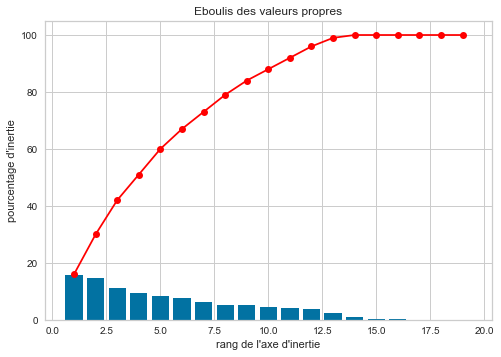

In [44]:
#on affiche graphiquement l'ebouli
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.

Les huit premières composantes principales expliquent environ 80% de la variance.

### Correlation graph

On va tracer le cercle de corrélation qui permet de montrer graphiquement sur chaque plan en 2D les corrélations entre les variables

On doit definir nos axes x et y. 
On va utiliser les 2 premières composantes. 
Comme - en code - on commence à compter à partir de 0, cela nous donne :

In [45]:
#fontion pour tracer le cercle de correlation
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

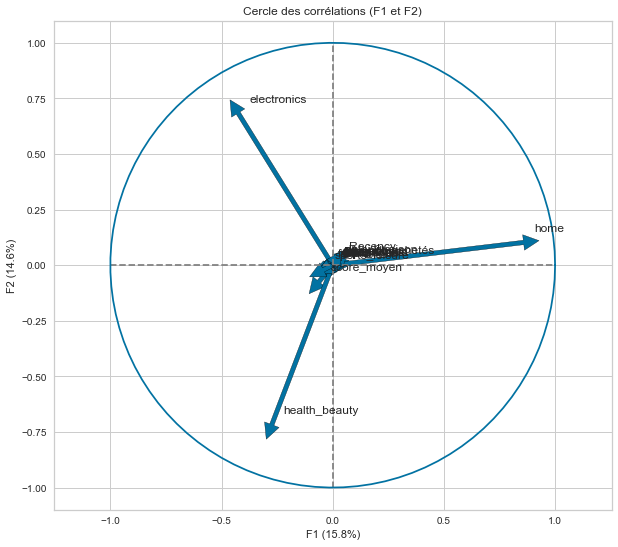

In [46]:
#pour F1 et F2
correlation_graph(pca, (0,1), features)

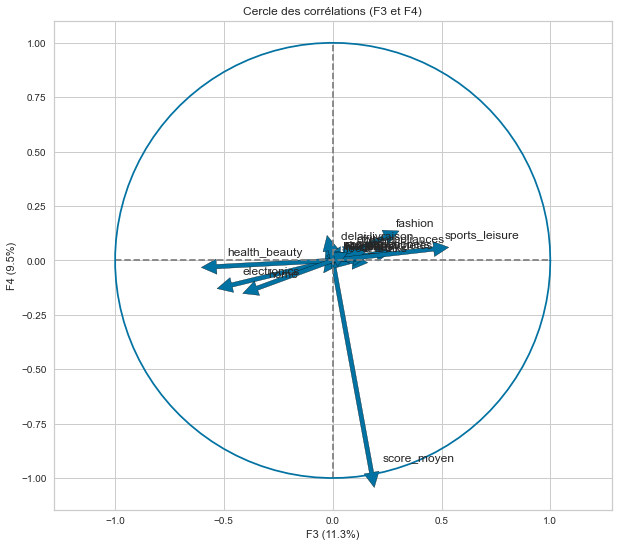

In [47]:
#pour F3 et F4
correlation_graph(pca, (2,3), features)

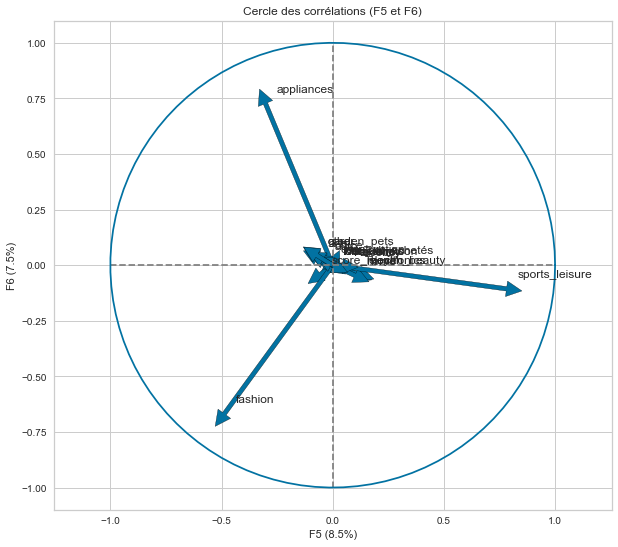

In [48]:
#pour F5 et F6
correlation_graph(pca, (4,5), features)

Le poids de features des variables catégories de produit masque les autres axes de catégorisation, nous allons donc réaliser un nouveau K-Means en supprimant ces variables. 
Leur presence peut brouiller les clusters et enlever leur intérêt d'un point de vue métier.

### Troisième essai
On essait avec le RFM et le score_moyen des commandes

In [49]:
df_RFM_SM = df[['Recency', 'Frequency', 'Monetary','score_moyen']]

In [50]:
#On standardise les données 
minmax_scaler = MinMaxScaler()

X_scaled_RFM_SM = minmax_scaler.fit_transform(df_RFM_SM)
df_RFM_SM_scaled = pd.DataFrame(X_scaled_RFM_SM)
df_RFM_SM_scaled.columns = df_RFM_SM.columns
df_RFM_SM_scaled.head()

,Recency,Frequency,Monetary,score_moyen
0,0.159942,0.0,0.010384,1.00
1,0.164265,0.0,0.001989,0.75
2,0.772334,0.0,0.006309,0.50
3,0.461095,0.0,0.003192,0.75
4,0.413545,0.0,0.014409,1.00


### Deuxième clustering avec les 3 variables RFM et le Score moyen

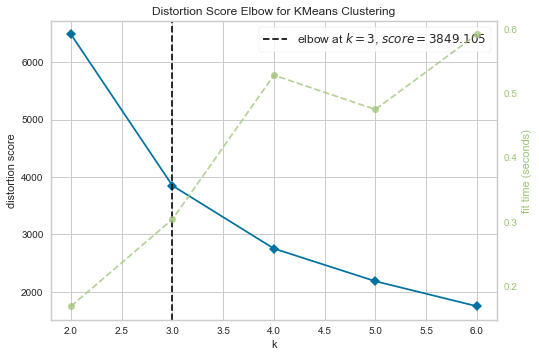

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
# Methode du coude "Elbow Method" : detecter une zone de coude dans la minimisation du cout (inertia)
# On trace l'evolution du cout de notre modele en fonction du nombre de clusters 
# pour detecter la zone de coude : nous indique le nombre de cluster optimal (qui reduit au max le cout de notre modèle)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7))

visualizer.fit(X_scaled_RFM_SM)    # Fit the data to the visualizer
visualizer.poof()                  # Draw/show/poof the data

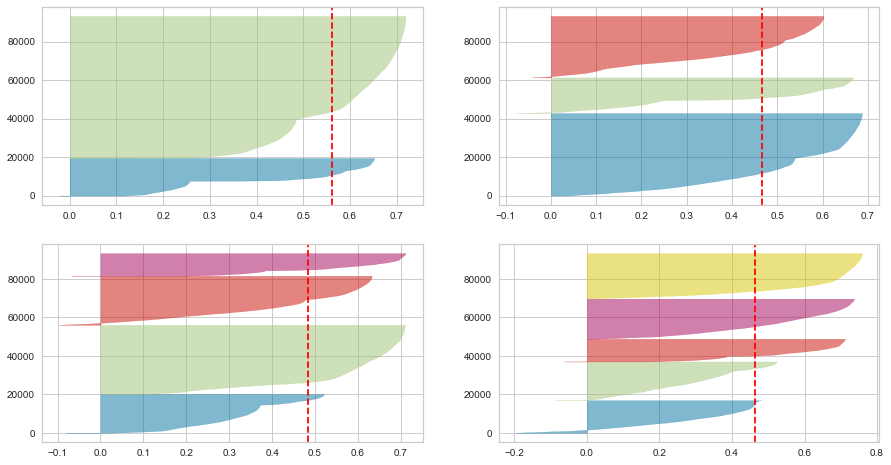

In [52]:
# on va afficher le Silhouette Visualizer pour plusieurs taille de clusters 
fig, ax = plt.subplots(2, 2, figsize=(15,8))
liste_clusters = []
for i in [2, 3, 4, 5]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    #Create SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled_RFM_SM)

#### On va choisir 3 clusters car c'est avec ce nombre de clusters qu'il y a une repartition la plus égale et que le score de Silhouette moyen est presque à 0.5 et surtout c'est ce nombre de cluster qui permet un clustering pertinent d’un point de vue métier

In [53]:
# On initialise le kmeans et on fit aux données
kmeans_RFM_SM = KMeans(3)
kmeans_RFM_SM.fit(X_scaled_RFM_SM)
# On peut stocker nos clusters dans une variable labels
labels_RFM_SM = kmeans_RFM_SM.labels_
labels_RFM_SM

array([1, 1, 0, ..., 0, 1, 0], dtype=int32)

#### PCA de dimension 2 pour visualiser les clusters

In [54]:
# on fait une ACP avec 2 composantes
pca_RFM_SM = decomposition.PCA(n_components=2)
pca_RFM_SM.fit(X_scaled_RFM_SM)

# Pourcentage de variance expliqué par la premiere composente, par les deux premieres composantes ensemble
print(pca_RFM_SM.explained_variance_ratio_.cumsum())
X_proj_RFM_SM = pca_RFM_SM.transform(X_scaled_RFM_SM)
X_proj_RFM_SM = pd.DataFrame(X_proj_RFM_SM, columns = ["PC1", "PC2"])

# On a 99% de la variance des données qui expliqué par ces deux premières composantes
# on peut dire que c'est pas absurde d'utiliser ces 2 composantes pour representer les données

[0.67581255 0.99673911]


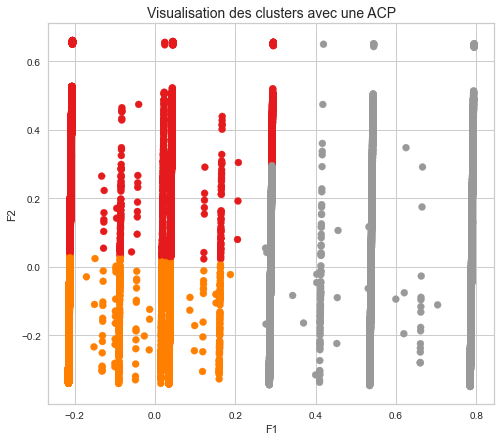

In [55]:
#on affiche les clusters 
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.scatter(X_proj_RFM_SM.iloc[:, 0], X_proj_RFM_SM.iloc[:, 1], c= labels_RFM_SM, cmap="Set1")
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.title('Visualisation des clusters avec une ACP', size=14)
plt.show()

In [56]:
#Pour chaque valeur « k » sélectionnée, on vérifie le nombre de clients par cluster.
#Si ce nombre est trop faible pour certains clusters, la valeur « k » n’est pas pertinente d’un point de vue métier.
# ici les clusters sont plutot equilibrés 
df_RFM_SM['cluster'] = labels_RFM_SM
df_RFM_SM['cluster'].value_counts()

1    42891
0    31943
2    18515
Name: cluster, dtype: int64

#### Pour chaque feature, un graphique de boxplot par cluster

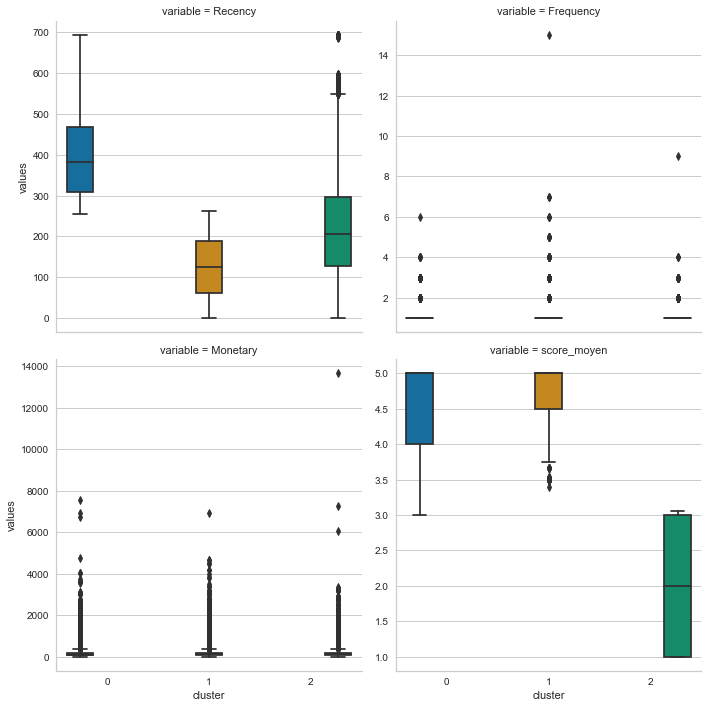

In [57]:
df_long = df_RFM_SM.melt(id_vars='cluster',
                    value_vars=df_RFM_SM.columns[:-1],
                    var_name='variable', 
                    value_name='values')

sns.catplot(kind='box', data=df_long, 
            col='variable', 
            y='values', 
            x='cluster',
            hue='cluster',
            palette="colorblind",
            sharey=False, 
            col_wrap=2)

plt.tight_layout()
plt.show()

#### Des graphiques d’analyse bivariée entre 2 features

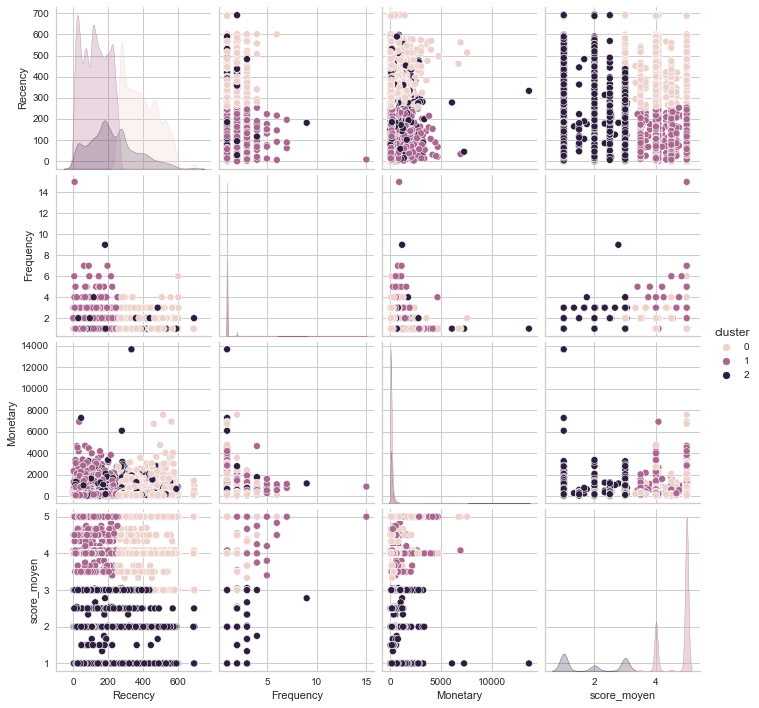

In [58]:
sns.pairplot(df_RFM_SM, hue="cluster")

#### Calcul de moyenne par cluster pour chaque feature

In [59]:
group_columns = df_RFM_SM.groupby('cluster').mean()
group_columns.head()

,Recency,Frequency,Monetary,score_moyen
cluster,,,,
0,393.665592,1.029553,159.268630,4.669727
1,125.491898,1.038236,158.629167,4.750053
2,224.749824,1.028950,176.956632,1.879737


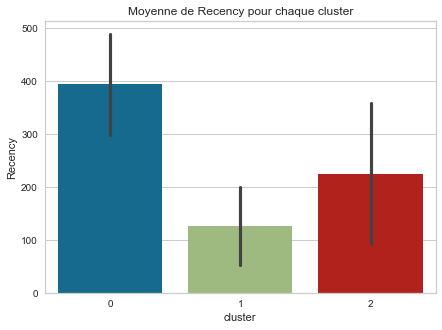

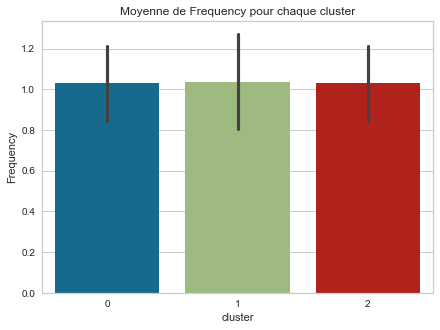

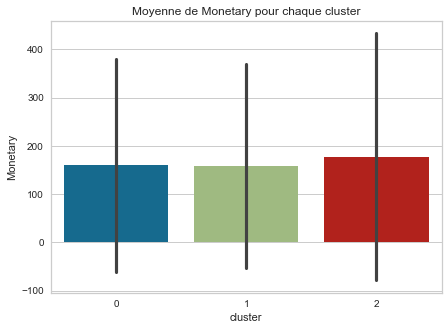

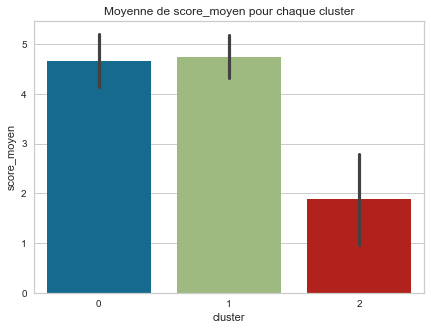

In [60]:
for column in group_columns.columns:
    try:
        plt.figure(figsize=(7,5))
        titre = 'Moyenne de ' + str(column) + ' pour chaque cluster' 
        plt.title(titre)
        sns.barplot(x = 'cluster',
                    y = column,
                    data = df_RFM_SM, 
                    ci="sd")
        plt.show()
    except:
        print('Erreur colonne : ', column)

#### On va essayer de rajouter des variables pour pouvoir formaliser un profil de clients par cluster

### Quatrième essai
On rajoute les variables delai de livraison et nombre de produits achetés 

In [61]:
#on va rajouter les variables delai de livraison et nombre de pdt achetés
df_4 = df[['Recency',
           'Frequency',
           'Monetary',
           'delai livraison',
           'score_moyen',
           #'nbr_pdt_achetés'
          ]]

In [62]:
#On standardise les données 
minmax_scaler = MinMaxScaler()

X_scaled_4 = minmax_scaler.fit_transform(df_4)
df_4_scaled = pd.DataFrame(X_scaled_4)
df_4_scaled.columns = df_4.columns
df_4_scaled.head()

,Recency,Frequency,Monetary,delai livraison,score_moyen
0,0.159942,0.0,0.010384,0.028708,1.00
1,0.164265,0.0,0.001989,0.014354,0.75
2,0.772334,0.0,0.006309,0.119617,0.50
3,0.461095,0.0,0.003192,0.095694,0.75
4,0.413545,0.0,0.014409,0.062201,1.00


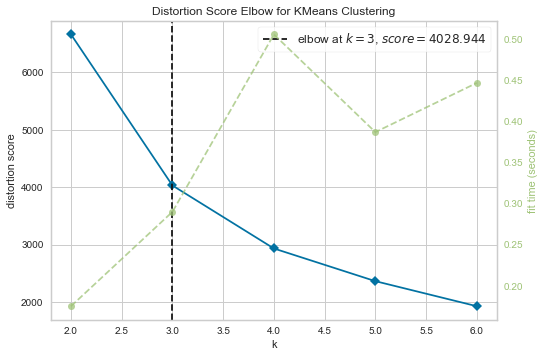

In [63]:
# Methode du coude "Elbow Method" : detecter une zone de coude dans la minimisation du cout (inertia)
# On trace l'evolution du cout de notre modele en fonction du nombre de clusters 
# pour detecter la zone de coude : nous indique le nombre de cluster optimal (qui reduit au max le cout de notre modèle)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7))

visualizer.fit(X_scaled_4)    # Fit the data to the visualizer
visualizer.poof();            # Draw/show/poof the data

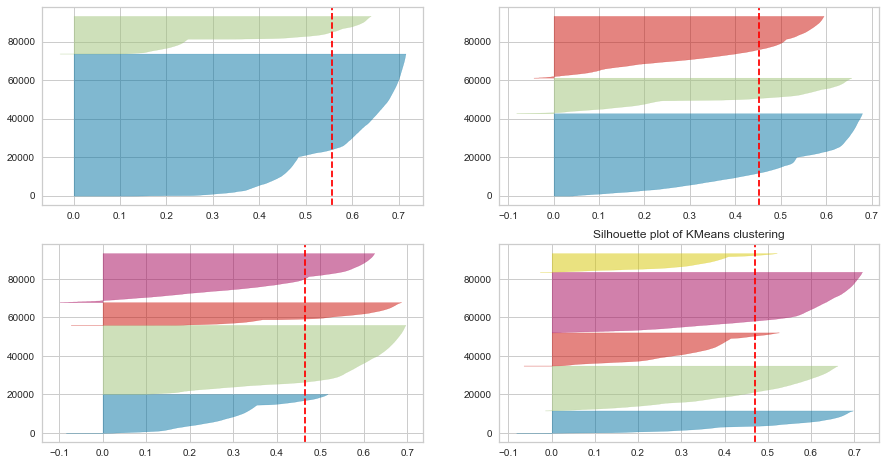

In [64]:
# on va afficher le Silhouette Visualizer pour plusieurs taille de clusters 
fig, ax = plt.subplots(2, 2, figsize=(15,8))
liste_clusters = []
for i in [2, 3, 4, 5]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    #Create SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    plt.title('Silhouette plot of KMeans clustering')
    visualizer.fit(X_scaled_4)

#### On va choisir 4 clusters car avec nombre de clusters il y a une repartition assez égale et le score de Silhouette moyen est proche 0.5 mais que surtout c'est ce nombre de cluster qui permet un clustering pertinent d’un point de vue métier

In [65]:
# On initialise le kmeans et on fit aux données
kmeans_4 = KMeans(3)
kmeans_4.fit(X_scaled_4)
# On peut stocker nos clusters dans une variable labels : 
labels_4 = kmeans_4.labels_

#### PCA de dimension 2 pour visualiser les clusters

In [66]:
# on fait une ACP avec 2 composantes 
pca_4 = decomposition.PCA(n_components=2)
pca_4.fit(X_scaled_4)

# Pourcentage de variance expliqué par la premiere composente, par les deux premieres composantes ensemble
print(pca_4.explained_variance_ratio_.cumsum())
X_proj_4 = pca_4.transform(X_scaled_4)
X_proj_4 = pd.DataFrame(X_proj_4, columns = ["PC1", "PC2"])

# On a 98% de la variance des données qui est expliquée par les deux premières composantes
# on peut dire que c'est pas absurde d'utiliser 2 composantes pour representer les données


[0.668023   0.98464257]


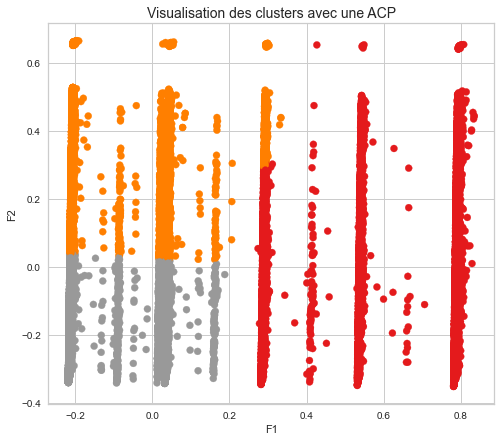

In [67]:
# On affiche les clusters 
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.scatter(X_proj_4.iloc[:, 0], X_proj_4.iloc[:, 1], c= labels_4, cmap="Set1")
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.title('Visualisation des clusters avec une ACP', size=14)
plt.show()

In [68]:
# on crée une variable cluster 
df_4['cluster'] = labels_4
df_4['cluster'].value_counts()

2    42791
1    32065
0    18493
Name: cluster, dtype: int64

#### Pour chaque feature, un graphique de boxplot par cluster

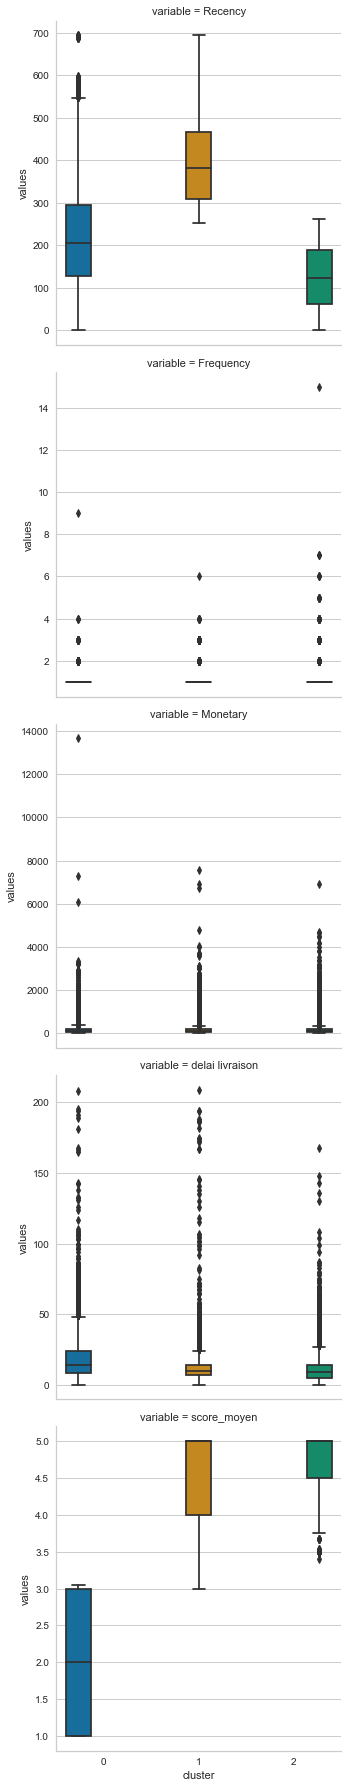

In [69]:
# on va afficher des boxplots pour chaque features et chaque cluster
df_long = df_4.melt(id_vars='cluster',
                    value_vars=df_4.columns[:-1],
                    var_name='variable', 
                    value_name='values')

sns.catplot(kind='box', data=df_long, 
            col='variable', 
            y='values', 
            x='cluster',
            hue='cluster',
            palette="colorblind",
            sharey=False, 
            col_wrap=1)

plt.tight_layout()
plt.show()

#### Des graphiques d’analyse bivariée entre 2 features

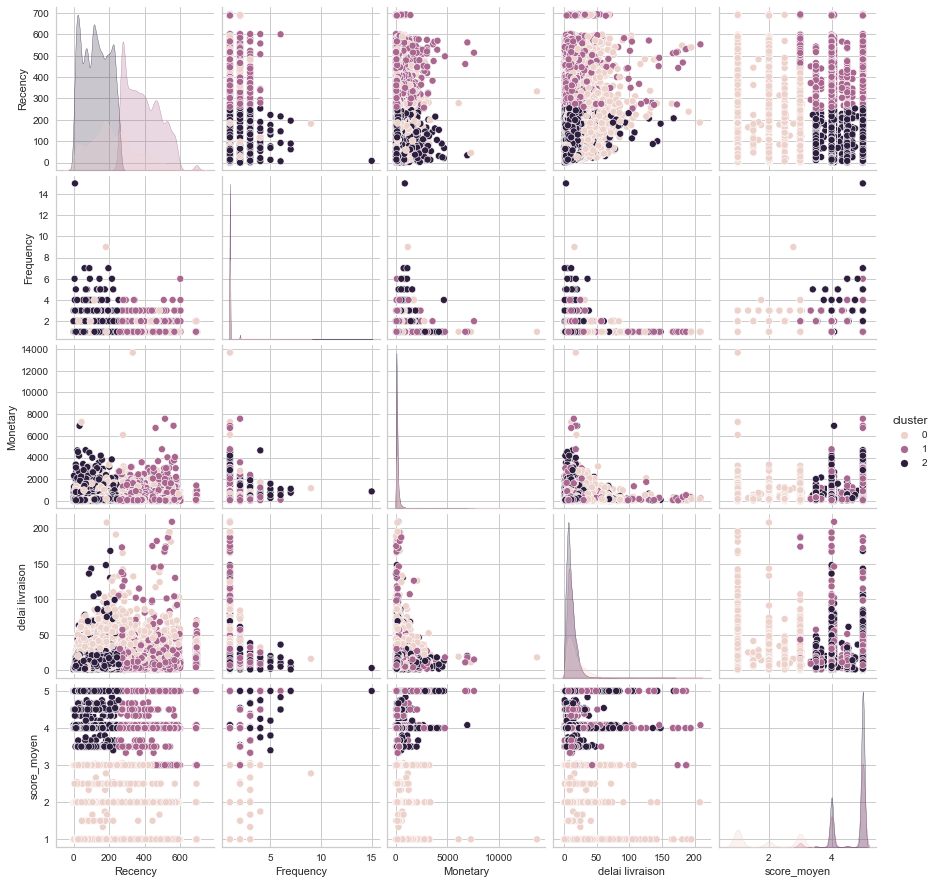

In [70]:
sns.pairplot(df_4, hue="cluster")

#### Pour chaque feature, on calcule la moyenne par cluster

In [71]:
group_columns = df_4.groupby('cluster').mean()
group_columns.head()

,Recency,Frequency,Monetary,delai livraison,score_moyen
cluster,,,,,
0,224.490240,1.029038,177.014060,17.719137,1.878405
1,393.278123,1.029409,159.207576,11.414439,4.668458
2,125.180879,1.038326,158.657698,10.235447,4.750334


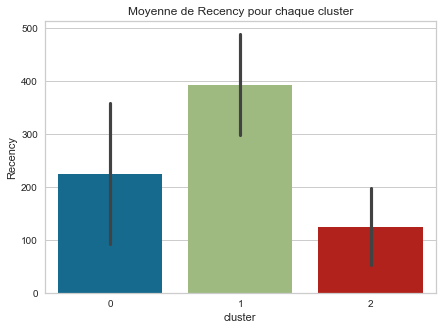

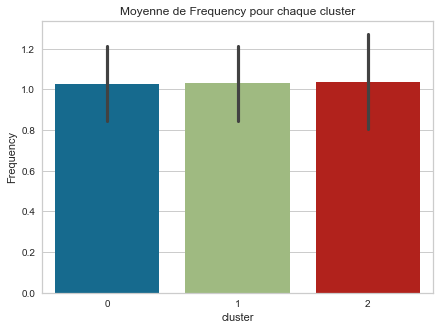

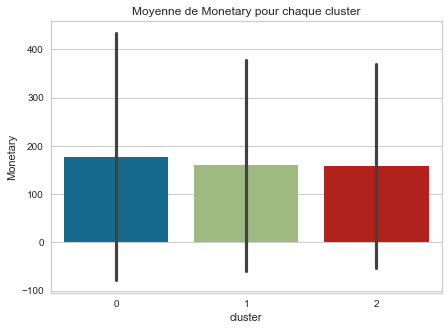

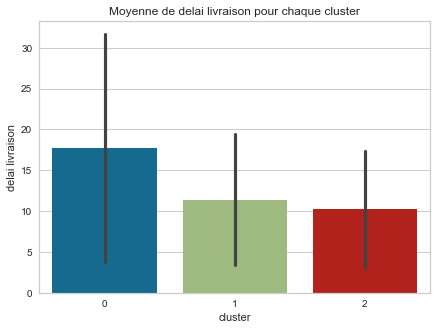

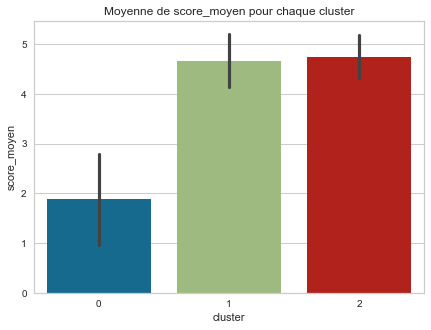

In [72]:
for column in group_columns.columns:
    try:
        plt.figure(figsize=(7,5))
        titre = 'Moyenne de ' + str(column) + ' pour chaque cluster' 
        plt.title(titre)
        sns.barplot(x = 'cluster',
                    y = column,
                    data = df_4, 
                    ci="sd")
        plt.show()
    except:
        print('Erreur colonne : ', column)

#### Conclusion sur le profil de clients par cluster

- Cluster 0 : les délais de livraison des ces clients sont courts et ce sont des clients qui ont commandés récemment. Les scores de ces clients sont excellents. Cela regroupe des clients avec un nombre de commande élevé et avec des montants moyens.

- cluster 1 : Ce sont des clients mécontents. En effet, le délai de livraison des commandes de ces clients est élevé et les montants de leurs commandes sont élevés. Ce sont des clients qui ont commandés récemment. 

- cluster 2 : Ce cluster regroupe des clients dont leur dernière commande commence à dater. Il regroupe aussi des clients avec des montants élevés et un nombre de commande moyen. Les scores donnés par ces clients sont plutôt bons et le délai de livraison pour ces clients sont assez courts.

En conclusion, le groupe 0 représente les clients les plus intéressants. Ce groupe représente des clients fidèles.
Le groupe 1 corresponds aux clients mécontents donc plutôt retissant à recommander.

## Algorithme de DBScan 

Le DBSCAN est un algorithme simple qui définit des clusters en utilisant l’estimation de la densité locale. On peut le diviser en 4 étapes :

- Pour chaque observation on regarde le nombre de points à au plus une distance ε de celle-ci. On appelle cette zone le ε-voisinage de l’observation.
- Si une observation compte au moins un certain nombre de voisins y compris elle-même, elle est considérée comme une observation cœur. On a alors décelé une observation à haute densité.
- Toutes les observations au voisinage d’une observation cœur appartiennent au même cluster. Il peut y avoir des observations cœur proche les unes des autres. Par conséquent de proche en proche on obtient une longue séquence d’observations cœur qui constitue un unique cluster.
- Toute observation qui n’est pas une observation cœur et qui ne comporte pas d’observation cœur dans son voisinage est considérée comme une anomalie.

Avantages :

Contrairement à l’algorithme des k-moyennes ou la classification ascendante hiérarchique, il n’y a pas besoin de définir en amont le nombre de clusters ce qui rend l’algorithme moins rigide. Un autre avantage de DBSCAN est qu’il permet aussi de gérer les valeurs aberrantes ou anomalies.

Inconvénients :

Il ne fonctionne pas aussi bien que d’autres lorsque les clusters ont une densité variable (le réglage du seuil de distance ε et de minPoints pour l’identification des points de voisinage varie d’un cluster à l’autre lorsque la densité varie).
Il n’est pas performant avec des données de très haute dimension car le seuil de distance ε devient difficile à estimer.

In [73]:
df_5 = df[['Recency',
           'Frequency',
           'Monetary',
           'delai livraison',
           'score_moyen',
          ]]

In [74]:
#On standardise les données 
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()

X_scaled_5 = std_scaler.fit_transform(df_5)
df_5_scaled = pd.DataFrame(X_scaled_5)
df_5_scaled.columns = df_5.columns
df_5_scaled.head()

,Recency,Frequency,Monetary,delai livraison,score_moyen
0,-0.825425,-0.159837,-0.091918,-0.637879,0.663545
1,-0.805763,-0.159837,-0.604177,-0.950413,-0.120104
2,1.959963,-0.159837,-0.340567,1.341498,-0.903754
3,0.544331,-0.159837,-0.530806,0.820609,-0.120104
4,0.328053,-0.159837,0.153651,0.091365,0.663545


In [75]:
dbs = DBSCAN(eps = 1,          #epsilon :the maximum distance between two obsertavions for them to be considered within the same cluster
             min_samples=100,  #minimum cluster size
             n_jobs=-1)        # 

In [76]:
dbs.fit(X_scaled_5)

DBSCAN(eps=1, min_samples=100, n_jobs=-1)

In [77]:
# on crée une variable cluster 
df_5['cluster'] = dbs.labels_
df_5['cluster'].value_counts()

 0    89467
 1     2211
-1     1671
Name: cluster, dtype: int64

On voit que le cluster 0 contient 80 722 clients comparé au cluster 4 qui en contient 234

In [78]:
# Number of clusters in labels, ignoring noise if present
labels = dbs.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_scaled_5, labels))

Estimated number of clusters: 2
Estimated number of noise points: 1671
Silhouette Coefficient: 0.565


#### ACP de dimension 2 pour visualiser les clusters

In [79]:
# on fait une ACP avec 2 composantes 
pca_5 = decomposition.PCA(n_components=2)
pca_5.fit(X_scaled_5)

# Pourcentage de variance expliqué par la premiere composente, par les deux premieres composantes ensemble
print(pca_5.explained_variance_ratio_.cumsum())
X_proj_5 = pca_5.transform(X_scaled_5)
X_proj_5 = pd.DataFrame(X_proj_5, columns = ["PC1", "PC2"])

# On a 49% de la variance des données qui est expliquée par les deux premières composantes

[0.27263159 0.4965027 ]


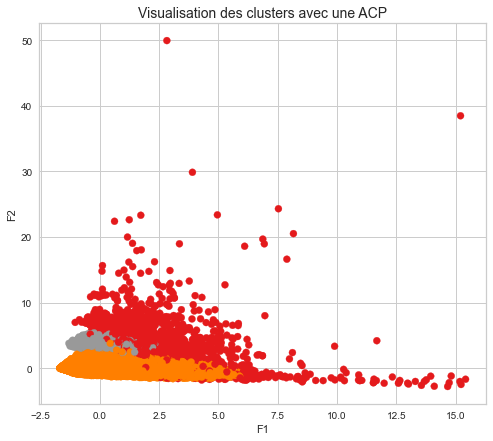

In [80]:
# On affiche les clusters 
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.scatter(X_proj_5.iloc[:, 0], X_proj_5.iloc[:, 1], c= labels, cmap="Set1")
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.title('Visualisation des clusters avec une ACP', size=14)
plt.show()

### En conclusion, le DBSCAN n'est pas adapté car le nombre de clients sans cluster (cluster -1) est trop élevé et les clusters proposés ne contiennent pas un nombre homogène de clients

## Algorithme d'agglomerative clustering : CAH sur un echantillon du dataset

L’idée de départ est de considérer que chacun des points de votre jeu de données est un centroïde. Cela revient à considérer qu’à chaque point correspond une unique étiquette (0,1,2,3, 4…). 

Ensuite on regroupe chaque centroïde avec son centroïde voisin le plus proche. Ce dernier prend l’étiquette du centroïde qui l’a « absorbé ». 

On calcule alors les nouveaux centroïdes qui seront les centres de gravité des clusters nouvellement créés. 

On réitère l’opération jusqu’à obtenir un unique cluster ou bien un nombre de clusters préalablement défini. 

In [83]:
df_6 = df[['Recency',
           'Frequency',
           'Monetary',
           'delai livraison',
           'score_moyen'
          ]]

In [84]:
# Pour réduire le temps de traitement, on va travailler sur un echantillon du fichier
X_train, X_test = train_test_split(df_6, test_size=0.8, random_state=0)
#on crée le dataframe réduit ””
df_6_reduit = pd.DataFrame(X_train)
df_6_reduit.columns = df_6.columns
df_6_reduit.head()

,Recency,Frequency,Monetary,delai livraison,score_moyen
73744,244,1,114.34,12,5.0
42955,186,1,68.02,10,5.0
51217,406,1,103.55,2,5.0
50879,325,2,109.36,15,5.0
26807,221,1,141.14,37,1.0


In [85]:
#On standardise les données 
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()

X_scaled_6 = minmax_scaler.fit_transform(X_train)

In [86]:
# Génération de la matrice des liens
Z = linkage(X_scaled_6, method = 'ward', metric = 'euclidean')
print(len(Z))
print(len(df.index));

18668
93349


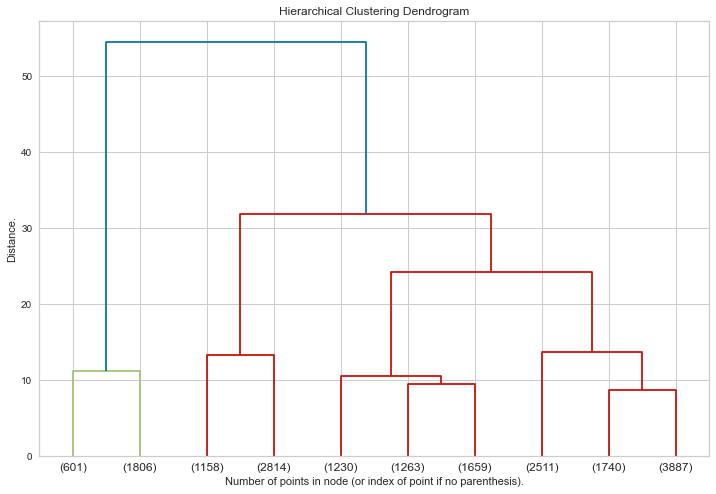

In [87]:
# On affiche notre dendogramme
# Mais on ne veut que 10 clusters affichés pour ne pas avoir un arbre illisible

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

_ = dendrogram(Z, p=10, truncate_mode="lastp", ax=ax)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

La classification produit une hiérarchie entre les clusters à toutes les étapes de l'algorithme : au sommet de la hiérarchie, tous les points sont regroupés et en bas de la hiérarchie, tous les points sont isolés.

Un dendrogramme montre les différents clusters obtenus à chaque étape.
La première ligne représente les données et les nœuds représentent les regroupements auxquels les données appartiennent.


Une fois les différents clusters obtenus, il est possible de choisir le nombre de cluster optimal en coupant le dendrogramme au plus grand saut entre deux clusters consécutifs.
Le nombre optimal de clusters correspond alors au nombre de lignes verticales traversées par la coupe horizontale du dendrogramme.

In [88]:
#on va comparer les scores de silhouettes pour différents nombre de clusters

# Définition de la liste de n_clusters
range_n_clusters = [2, 3, 4, 5, 6, 7]

# Initialisation de la liste des coefficients de la silhouette score
s_scores = []

# Calcul du coefficient de silhouette pour les différentes valeurs de n_clusters
for n_clusters in range_n_clusters :
    
    # Initialisation du classificateur CAH pour n_clusters
    cluster = AgglomerativeClustering(n_clusters = n_clusters)

    # Apprentissage des données 
    cluster.fit(X_scaled_6)

    # Calcul des labels du data set
    labels = cluster.labels_
    
    # Caclul du coefficient de silhouette
    s_score = metrics.silhouette_score(X_scaled_6, labels, metric='sqeuclidean')
    s_scores.append(s_score)

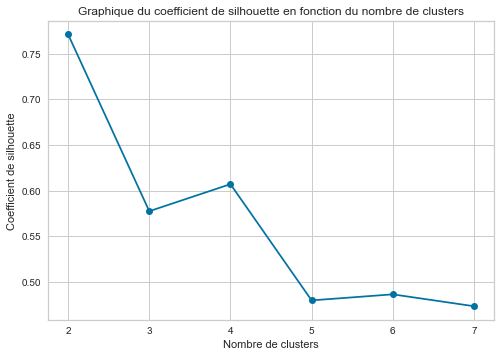

In [89]:
# Graphique du coefficient de silhouette en fonction du nombre de clusters
plt.plot(range_n_clusters, s_scores, 'bo-')
plt.title('Graphique du coefficient de silhouette en fonction du nombre de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.show()


In [96]:
# Initialisation du classificateur CAH
#on choisit 3 clusters 

cah = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')

# Apprentissage des données 
cah.fit(X_scaled_6)

# Calcul des labels du data set
labels = cah.labels_
#on ajoute les clusters à une variable
df_6_reduit['cluster'] = labels
df_6_reduit['cluster'].value_counts()

# Calcul du coefficient silhouette
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_scaled_6, labels, metric='sqeuclidean'))

Silhouette Coefficient: 0.607


#### ACP de dimension 2 pour visualiser les clusters

In [97]:
# on fait une ACP avec 2 composantes 
pca_6 = decomposition.PCA(n_components=2)
pca_6.fit(X_scaled_6)

# Pourcentage de variance expliqué par la premiere composente, par les deux premieres composantes ensemble
print(pca_6.explained_variance_ratio_.cumsum())
X_proj_6 = pca_6.transform(X_scaled_6)
X_proj_6 = pd.DataFrame(X_proj_6, columns = ["PC1", "PC2"])

# On a 96% de la variance des données qui est expliquée par les deux premières composantes
# on peut dire que c'est pas absurde d'utiliser 2 composantes pour representer les données


[0.6683673  0.97280782]


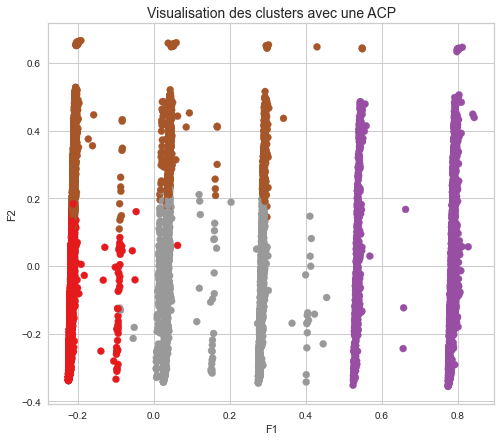

In [98]:
# On affiche les clusters 
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.scatter(X_proj_6.iloc[:, 0], X_proj_6.iloc[:, 1], c= labels, cmap="Set1")
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.title('Visualisation des clusters avec une ACP', size=14)
plt.show()

#### Pour chaque feature, un graphique de boxplot par cluster

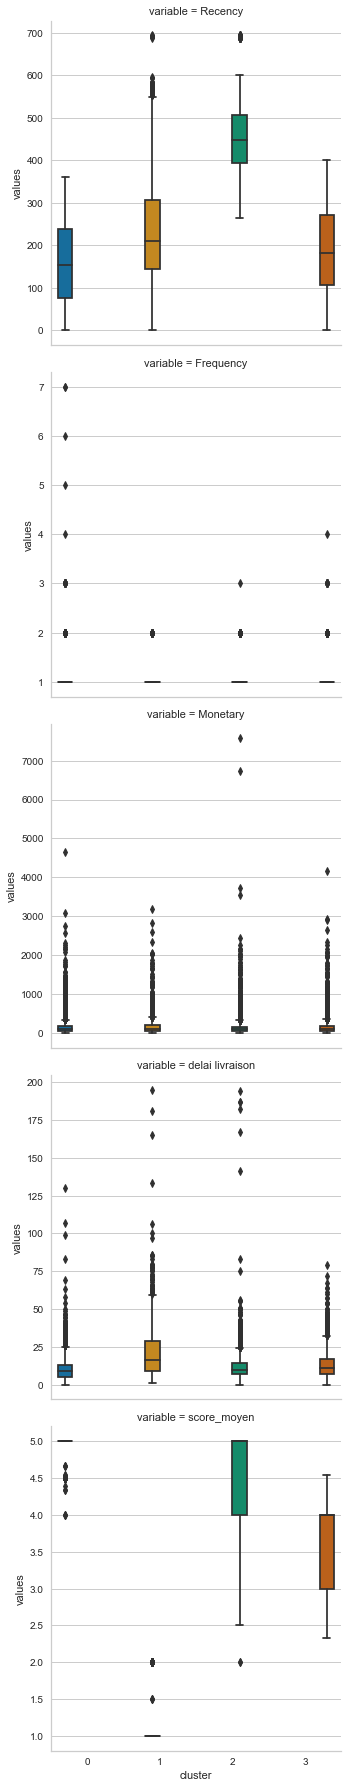

In [99]:
# on va afficher des boxplots pour chaque features et chaque cluster
df_long = df_6_reduit.melt(id_vars='cluster',
                    value_vars=df_6_reduit.columns[:-1],
                    var_name='variable', 
                    value_name='values')

sns.catplot(kind='box', data=df_long, 
            col='variable', 
            y='values', 
            x='cluster',
            hue='cluster',
            palette="colorblind",
            sharey=False, 
            col_wrap=1)

plt.tight_layout()
plt.show()

#### Des graphiques d’analyse bivariée entre 2 features

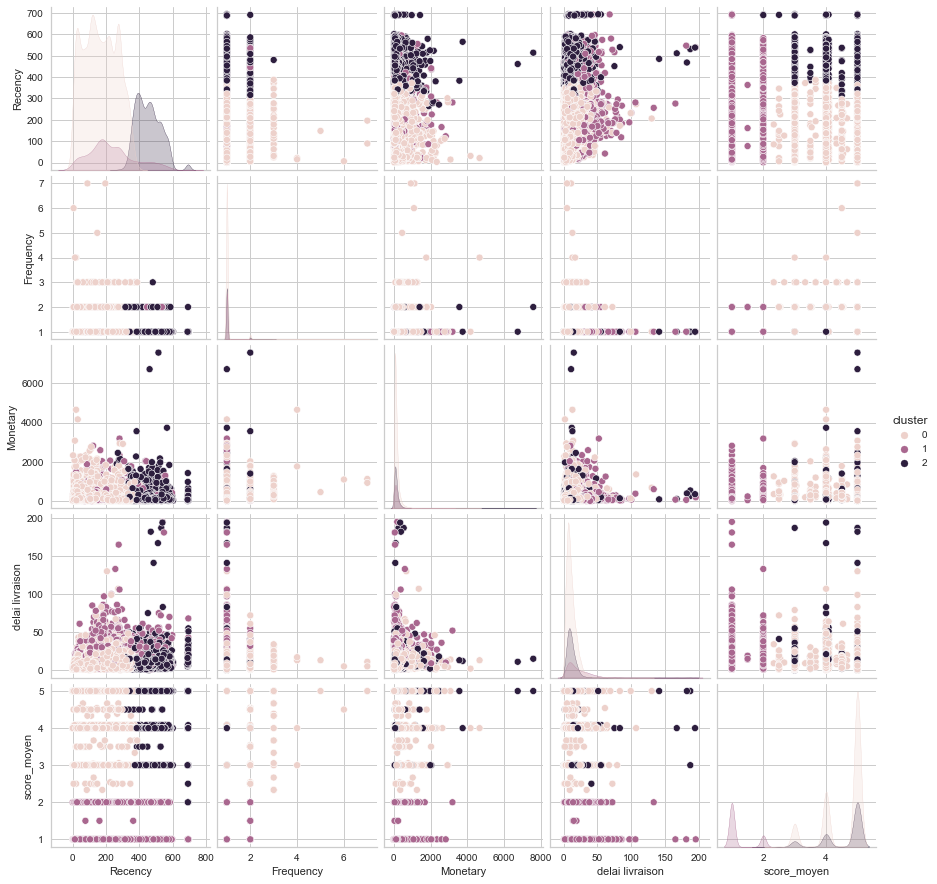

In [94]:
sns.pairplot(df_6_reduit, hue="cluster")

#### Pour chaque feature, un calcul de moyenne par cluster

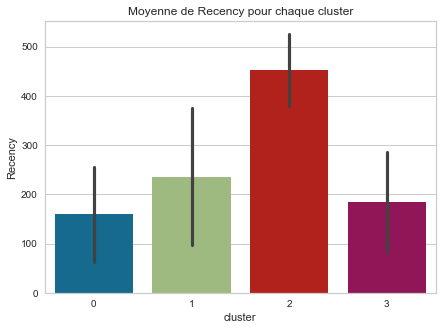

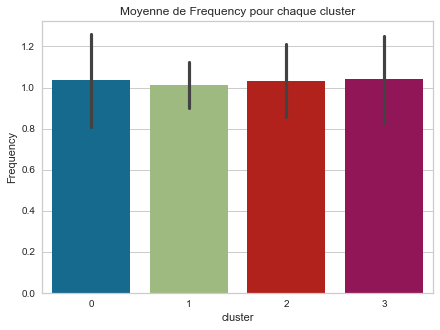

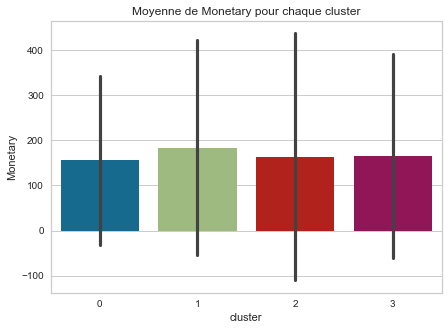

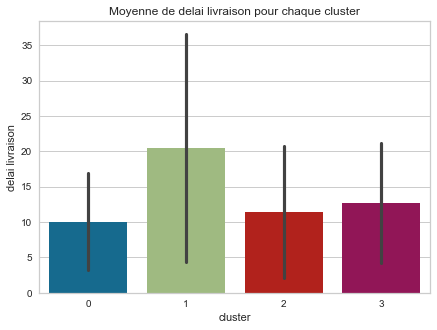

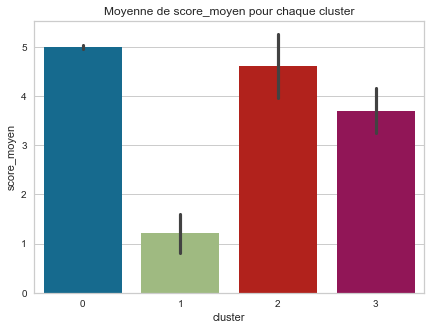

In [100]:
group_columns = df_6_reduit.groupby('cluster').mean()
for column in group_columns.columns:
    try:
        plt.figure(figsize=(7,5))
        titre = 'Moyenne de ' + str(column) + ' pour chaque cluster' 
        plt.title(titre)
        sns.barplot(x = 'cluster',
                    y = column,
                    data = df_6_reduit, 
                    ci="sd")
        plt.show()
    except:
        print('Erreur colonne : ', column)

#### Les résultats sont proche de ceux de l'algorithme KMeans mais on a été obligé de réduire le dataset à cause du temps de traitement de l'algorithme
#### Par conséquent, l'algorithme choisit est le KMEANS avec les variables 'Recency','Frequency','Monetary','delai livraison','score_moyen' et 3 clusters.